In [49]:

!conda install -c conda-forge geopy --yes 
!conda install -c conda-forge folium=0.5.0 --yes 
import numpy as np 

import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json 

from geopy.geocoders import Nominatim 

import requests

from pandas.io.json import json_normalize

import matplotlib.cm as cm

import matplotlib.colors as colors

from sklearn.cluster import KMeans

from bs4 import BeautifulSoup

import xml

import folium 

print('Libraries are installed!')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Libraries are installed!


In [73]:
import matplotlib
import matplotlib.pyplot as plt

## Read Simple Map dataset to get districts in Danang and coordinates ##

In [59]:
df_allcities = pd.read_csv('vn.csv')
df_district = df_allcities[df_allcities['admin'] == 'Đà Nẵng']
df_district.reset_index(drop= True, inplace = True)
df_district

,city,lat,lng,country,iso2,admin,capital,population,population_proper
0,Đà Nẵng,16.074806,108.223958,Vietnam,VN,Đà Nẵng,admin,1000000.0,887069.0
1,Thanh Khê,16.070599,108.191021,Vietnam,VN,Đà Nẵng,minor,NaN,NaN
2,Sơn Trà,16.060681,108.232563,Vietnam,VN,Đà Nẵng,minor,NaN,NaN
3,Liên Chiểu,16.072723,108.158147,Vietnam,VN,Đà Nẵng,minor,NaN,NaN
4,Hòa Vang,15.987636,108.138927,Vietnam,VN,Đà Nẵng,minor,NaN,NaN
5,Cẩm Lệ,16.017714,108.203809,Vietnam,VN,Đà Nẵng,minor,NaN,NaN
6,Ngũ Hành Sơn,16.016178,108.253355,Vietnam,VN,Đà Nẵng,minor,NaN,NaN


### Exclude Đà Nẵng and Hòa Vang because Đà Nẵng is name of the city, Hoa Vang is an agricultural area ###

In [60]:
df_district.drop([4], inplace = True)
df_district.reset_index(drop=True, inplace = True)
df_district

,city,lat,lng,country,iso2,admin,capital,population,population_proper
0,Đà Nẵng,16.074806,108.223958,Vietnam,VN,Đà Nẵng,admin,1000000.0,887069.0
1,Thanh Khê,16.070599,108.191021,Vietnam,VN,Đà Nẵng,minor,NaN,NaN
2,Sơn Trà,16.060681,108.232563,Vietnam,VN,Đà Nẵng,minor,NaN,NaN
3,Liên Chiểu,16.072723,108.158147,Vietnam,VN,Đà Nẵng,minor,NaN,NaN
4,Cẩm Lệ,16.017714,108.203809,Vietnam,VN,Đà Nẵng,minor,NaN,NaN
5,Ngũ Hành Sơn,16.016178,108.253355,Vietnam,VN,Đà Nẵng,minor,NaN,NaN


### Set client_id, client_secret, version number, radius and limit value ###

In [61]:

CLIENT_ID = 'J5NF1IJV3MHMCCMBR2OEBDWRG13KZPOHVUNVFOJDDNQEJGEG' # your Foursquare ID
CLIENT_SECRET = '1PZ3HNPD5KT2IBPBXC2AXTQZIEMX1NIEHVZGTX4SCV0VSOXD' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
radius = 5000
LIMIT = 100

### Get popular venues of five districts ###

In [62]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [63]:
i = 0
for latitude, longitude, city in zip(df_district.lat, df_district.lng, df_district.city):

    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        latitude, 
        longitude, 
        radius, 
        LIMIT)
    results = requests.get(url).json()

    venues = results['response']['groups'][0]['items']

    nearby_venues = json_normalize(venues)
 
    filtered_columns = ['venue.id','venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    nearby_venues =nearby_venues.loc[:, filtered_columns]
    nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
    nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
    nearby_venues['district'] = city

    if i == 0:
        df_venues = nearby_venues.copy()
        i= i+1
    else:
        df_venues = df_venues.append(nearby_venues, ignore_index=True)
df_venues.shape


(421, 6)

In [78]:
df_group = df_venues.groupby('district').count()
df_group.reset_index(inplace=True)
df_group.rename(columns={'id':'count'}, inplace=True)
df_group.drop(['name','categories', 'lat','lng'], axis = 1, inplace = True)
df_group

,district,count
0,Cẩm Lệ,30
1,Liên Chiểu,6
2,Ngũ Hành Sơn,85
3,Sơn Trà,100
4,Thanh Khê,100
5,Đà Nẵng,100


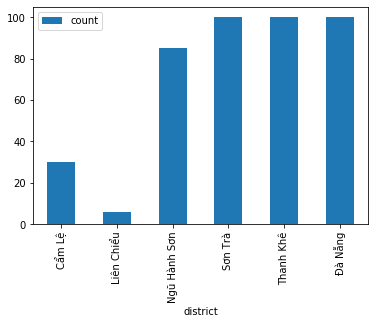

In [80]:
ax = df_group.plot(kind='bar',x='district', y = 'count')
ax.set_xlabel = 'Districts'
ax.set_ylabel = 'Numbers of venues'
ax.set_title = 'Statistic of venues in six districts'
plt.show()

In [64]:
adress = 'Danang, Vietnam'
geo = Nominatim(user_agent='LocationRecommendation')
location = geo.geocode(adress)
latitude = location.latitude
longitude = location.longitude
print('The position of Da Nang:{},{}'.format(latitude, longitude))

The position of Da Nang:16.068,108.212


In [134]:
df_venues= df_venues[df_venues['district']=='Đà Nẵng']

In [138]:
df_venues.shape

(100, 7)

In [135]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=12) # generate map centred around the Danang

# add a red circle marker to represent Danang
folium.features.CircleMarker(
    [latitude, longitude],
    radius=5,
    color='red',
    popup='Danang, Vietnam',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the venues as blue circle markers
for lat, lng, label in zip(df_venues.lat, df_venues.lng, df_venues.categories):
    popup1 = folium.Popup(label, parse_html=True)
    folium.features.CircleMarker(
        [lat, lng],
        radius=2,
        color='blue',
        popup=popup1,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

### Call Foursquare API to get visiting count of each venue  ###

In [ ]:
df_tipcount = pd.DataFrame(columns = ['id','tipcount'])
count = 0
for venue_id in df_venues['id']:
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,    
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    r = requests.get(url).json()
    venue = r['response']['venue']['stats']

    df_stats = json_normalize(venue)
    df_stats = pd.DataFrame({'id':venue_id, 'tipcount':df_stats['tipCount']})
    df_tipcount = df_tipcount.append(df_stats, ignore_index=True)
    count = count + 1
print('Count:{}'.format(count))


df_tipcount.shape        
        


In [84]:
df_venues.drop('Unnamed: 0', axis = 1, inplace=True)
df_venues.head()

,id,name,categories,lat,lng,district,visitsCount
0,5aabf13ed552c7495c4b16cc,Thien Ly Danang-style,Vietnamese Restaurant,16.076115,108.218690,Đà Nẵng,251
1,5a26a41a31ac6c676705e94c,cộng cà phê,Coffee Shop,16.068063,108.223512,Đà Nẵng,584
2,50389430e4b0fc42f753b8a3,Luna Pub,Italian Restaurant,16.079725,108.222998,Đà Nẵng,1635
3,582b1746641e5c276f013971,Pizza 4P's,Pizza Place,16.062675,108.222845,Đà Nẵng,1483
4,59d6062a67af3a61ae531b42,Herbal Spa,Spa,16.069384,108.236756,Đà Nẵng,377


### Cluster venues ###

In [127]:
from sklearn.preprocessing import StandardScaler

points = np.array(df_venues['visitsCount']).reshape(-1,1)
points = np.nan_to_num(points)
cluster_dataset = StandardScaler().fit_transform(points)
cluster_dataset

array([[-0.54517472],
       [-0.16336438],
       [ 1.04168868],
       [ 0.86740888],
       [-0.40070594],
       [-0.04297373],
       [-0.19890828],
       [ 2.22839649],
       [ 0.29755982],
       [-0.58759809],
       [ 0.2987064 ],
       [ 2.87850599],
       [-0.68964349],
       [-0.62887488],
       [-0.15075202],
       [ 0.08085665],
       [-0.35025652],
       [-0.4591814 ],
       [-0.47064717],
       [ 0.36864763],
       [-0.67015167],
       [-0.57039942],
       [ 1.58058015],
       [-0.53714867],
       [-0.61167622],
       [ 0.1909281 ],
       [ 0.48330539],
       [-0.51192397],
       [-0.01774902],
       [-0.27687556],
       [-0.66671194],
       [-0.60365017],
       [-0.58301178],
       [-0.46606086],
       [ 1.02334344],
       [-0.54976103],
       [-0.33993733],
       [-0.26197005],
       [ 0.19895414],
       [-0.68964349],
       [ 0.02582093],
       [-0.32388524],
       [-0.76187788],
       [-0.67129825],
       [-0.49357872],
       [ 1

### Find the optimal value of k for clustering ###

TypeError: 'str' object is not callable

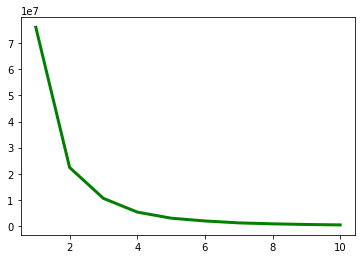

In [129]:
cost =[] 
for i in range(1, 11): 
    KM = KMeans(n_clusters = i, max_iter = 500) 
    KM.fit(points) 
      
    # calculates squared error 
    # for the clustered points 
    cost.append(KM.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 11), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot 
  
# the point of the elbow is the  
# most optimal value for choosing k 

In [130]:
kclusters=2

#run k-mean cluster
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(points)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [131]:
df_venues.drop('Cluster Labels', axis = 1, inplace = True)

### Add clustering labels ###

In [132]:
# add clustering labels
df_venues.insert(0, 'Cluster Labels', kmeans.labels_)

df_venues.head() # check the last columns!

,Cluster Labels,id,name,categories,lat,lng,district,visitsCount
0,0,5aabf13ed552c7495c4b16cc,Thien Ly Danang-style,Vietnamese Restaurant,16.076115,108.218690,Đà Nẵng,251
1,0,5a26a41a31ac6c676705e94c,cộng cà phê,Coffee Shop,16.068063,108.223512,Đà Nẵng,584
2,1,50389430e4b0fc42f753b8a3,Luna Pub,Italian Restaurant,16.079725,108.222998,Đà Nẵng,1635
3,0,582b1746641e5c276f013971,Pizza 4P's,Pizza Place,16.062675,108.222845,Đà Nẵng,1483
4,0,59d6062a67af3a61ae531b42,Herbal Spa,Spa,16.069384,108.236756,Đà Nẵng,377


### Create maps ###

In [133]:

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cluster in zip(df_venues['lat'], df_venues['lng'], df_venues['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters